In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from torch_tools import *
from wrappers import *
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 50
macro_configs = config_generator()
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

In [4]:
root_name = 'BPTT_CDI_b200_50_examples_ctx0'
file_names = []
for params, i_seed in micro_configs:
    
    if i_seed <= 25:
        continue
    
    np.random.seed(i_seed)
    T_trial = 100
    #task = Context_Dependent_Decision_Task(T_trial=T_trial, input_var=0.1, report_cue=True)
    task = Context_Dependent_Integration_Task(T_trial=T_trial, input_var=0.1)
    N_train = 10000000
    N_test = 20000
    checkpoint_interval = 10
    data = task.gen_data(N_train, N_test, add_dummy_end_point=False)
    batched_data = add_batch_dimension_to_data(data, T_trial)

    ### --- initialize RNN paramters and RNN object --- ###
    n_in = task.n_in
    n_hidden = 32
    n_out = task.n_out

    W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
    W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
    W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))
    b_rec = np.zeros(n_hidden)
    b_out = np.zeros(n_out)

    alpha = 0.1

    rnn = Torch_RNN(W_in, W_rec, W_out, b_rec, b_out,
                    activation='tanh',
                    alpha=alpha)
    
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
    scheduler = None
    checkpoints = train_torch_RNN(rnn, optimizer, batched_data,
                                  batch_size=200, n_epochs=4,
                                  L2_reg=0.0001, verbose=True,
                                  checkpoint_interval=checkpoint_interval,
                                  scheduler=scheduler)
    
    sim = Empty_Simulation()
    sim.checkpoints = checkpoints
    indices = sorted([k for k in checkpoints.keys() if type(k) != str])
    sim.checkpoint_interval = indices[1] - indices[0]
    sim.total_time_steps = indices[-1] + sim.checkpoint_interval
    sim.rnn = checkpoints['final']['rnn']
    
    #fix context to context 0
    task.fixed_context = 0
    
    file_name = root_name + '_seed={}'.format(i_seed)
    for key in params.keys():
        file_name += '_{}={}'.format(key, str(params[key]).replace('.', ','))
        
    file_names.append(file_name)
    
    print('finish simulation: ')
    for key in params.keys():
        print('{}:, {}, seed = {}'.format(key, params[key], i_seed))
    if np.isnan(rnn.W_rec.detach().numpy()[0, 0]):
        print('MISTAKES WERE MADE')
        break
    
    
    ### --- SAVE RUN --- ###
    with open(os.path.join('saved_runs/', file_name), 'wb') as f:
        saved_run = {'sim': sim, 'task': task}
        pickle.dump(saved_run, f)

Epoch 0, Batch 0
Loss 11.558405876159668
Epoch 0, Batch 50
Loss 0.430530309677124
Epoch 0, Batch 100
Loss 0.45392370223999023
Epoch 0, Batch 150
Loss 0.2653592824935913
Epoch 0, Batch 200
Loss 0.1834729164838791
Epoch 0, Batch 250
Loss 0.06730008125305176
Epoch 0, Batch 300
Loss 0.0672670379281044
Epoch 0, Batch 350
Loss 0.049550216645002365
Epoch 0, Batch 400
Loss 0.021415093913674355
Epoch 0, Batch 450
Loss 0.01694362238049507
Epoch 1, Batch 0
Loss 0.017810223624110222
Epoch 1, Batch 50
Loss 0.015693780034780502
Epoch 1, Batch 100
Loss 0.019318440929055214
Epoch 1, Batch 150
Loss 0.012351002544164658
Epoch 1, Batch 200
Loss 0.02101321332156658
Epoch 1, Batch 250
Loss 0.008644596673548222
Epoch 1, Batch 300
Loss 0.011587339453399181
Epoch 1, Batch 350
Loss 0.02013680338859558
Epoch 1, Batch 400
Loss 0.010759199038147926
Epoch 1, Batch 450
Loss 0.014481945894658566
Epoch 2, Batch 0
Loss 0.010838868096470833
Epoch 2, Batch 50
Loss 0.008717967197299004
Epoch 2, Batch 100
Loss 0.013146041

Epoch 2, Batch 250
Loss 0.01602097786962986
Epoch 2, Batch 300
Loss 0.0153220035135746
Epoch 2, Batch 350
Loss 0.008335752412676811
Epoch 2, Batch 400
Loss 0.005710067227482796
Epoch 2, Batch 450
Loss 0.010844333097338676
Epoch 3, Batch 0
Loss 0.013751575723290443
Epoch 3, Batch 50
Loss 0.006326414179056883
Epoch 3, Batch 100
Loss 0.007817990146577358
Epoch 3, Batch 150
Loss 0.005402767565101385
Epoch 3, Batch 200
Loss 0.005506849382072687
Epoch 3, Batch 250
Loss 0.01047555822879076
Epoch 3, Batch 300
Loss 0.011770499870181084
Epoch 3, Batch 350
Loss 0.021937353536486626
Epoch 3, Batch 400
Loss 0.005125250201672316
Epoch 3, Batch 450
Loss 0.005696757230907679
finish simulation: 
Epoch 0, Batch 0
Loss 19.536762237548828
Epoch 0, Batch 50
Loss 0.5221689343452454
Epoch 0, Batch 100
Loss 0.34954676032066345
Epoch 0, Batch 150
Loss 0.2714533805847168
Epoch 0, Batch 200
Loss 0.08467426896095276
Epoch 0, Batch 250
Loss 0.07295618206262589
Epoch 0, Batch 300
Loss 0.06781262904405594
Epoch 0, B

Epoch 0, Batch 400
Loss 0.033379241824150085
Epoch 0, Batch 450
Loss 0.03329908102750778
Epoch 1, Batch 0
Loss 0.041071321815252304
Epoch 1, Batch 50
Loss 0.03940661624073982
Epoch 1, Batch 100
Loss 0.023558160290122032
Epoch 1, Batch 150
Loss 0.023472411558032036
Epoch 1, Batch 200
Loss 0.029592735692858696
Epoch 1, Batch 250
Loss 0.025446103885769844
Epoch 1, Batch 300
Loss 0.02641092799603939
Epoch 1, Batch 350
Loss 0.016858650371432304
Epoch 1, Batch 400
Loss 0.015045599080622196
Epoch 1, Batch 450
Loss 0.02366984635591507
Epoch 2, Batch 0
Loss 0.018508173525333405
Epoch 2, Batch 50
Loss 0.022476444020867348
Epoch 2, Batch 100
Loss 0.01183316856622696
Epoch 2, Batch 150
Loss 0.016063516959547997
Epoch 2, Batch 200
Loss 0.0169532373547554
Epoch 2, Batch 250
Loss 0.014300921931862831
Epoch 2, Batch 300
Loss 0.009838446043431759
Epoch 2, Batch 350
Loss 0.01107003353536129
Epoch 2, Batch 400
Loss 0.009739143773913383
Epoch 2, Batch 450
Loss 0.009719927795231342
Epoch 3, Batch 0
Loss 0.

Epoch 3, Batch 100
Loss 0.00684354268014431
Epoch 3, Batch 150
Loss 0.004516584798693657
Epoch 3, Batch 200
Loss 0.00487462617456913
Epoch 3, Batch 250
Loss 0.004123747814446688
Epoch 3, Batch 300
Loss 0.006530501414090395
Epoch 3, Batch 350
Loss 0.006655305158346891
Epoch 3, Batch 400
Loss 0.008354450576007366
Epoch 3, Batch 450
Loss 0.015465564094483852
finish simulation: 
Epoch 0, Batch 0
Loss 29.333894729614258
Epoch 0, Batch 50
Loss 1.961867332458496
Epoch 0, Batch 100
Loss 0.7784451246261597
Epoch 0, Batch 150
Loss 0.5087384581565857
Epoch 0, Batch 200
Loss 0.28549137711524963
Epoch 0, Batch 250
Loss 0.15192459523677826
Epoch 0, Batch 300
Loss 0.12775388360023499
Epoch 0, Batch 350
Loss 0.1502339392900467
Epoch 0, Batch 400
Loss 0.10231471061706543
Epoch 0, Batch 450
Loss 0.10916648060083389
Epoch 1, Batch 0
Loss 0.05179262161254883
Epoch 1, Batch 50
Loss 0.07200992852449417
Epoch 1, Batch 100
Loss 0.07424759119749069
Epoch 1, Batch 150
Loss 0.04345430061221123
Epoch 1, Batch 200

Epoch 1, Batch 300
Loss 0.013900156132876873
Epoch 1, Batch 350
Loss 0.015192629769444466
Epoch 1, Batch 400
Loss 0.014681628905236721
Epoch 1, Batch 450
Loss 0.019063452258706093
Epoch 2, Batch 0
Loss 0.013382983393967152
Epoch 2, Batch 50
Loss 0.013820398598909378
Epoch 2, Batch 100
Loss 0.017407478764653206
Epoch 2, Batch 150
Loss 0.0132679408416152
Epoch 2, Batch 200
Loss 0.011498278006911278
Epoch 2, Batch 250
Loss 0.011317550204694271
Epoch 2, Batch 300
Loss 0.006814167369157076
Epoch 2, Batch 350
Loss 0.006952655501663685
Epoch 2, Batch 400
Loss 0.011147885583341122
Epoch 2, Batch 450
Loss 0.0196389090269804
Epoch 3, Batch 0
Loss 0.006282818038016558
Epoch 3, Batch 50
Loss 0.008162159472703934
Epoch 3, Batch 100
Loss 0.012108087539672852
Epoch 3, Batch 150
Loss 0.011265984736382961
Epoch 3, Batch 200
Loss 0.00893819984048605
Epoch 3, Batch 250
Loss 0.013753845356404781
Epoch 3, Batch 300
Loss 0.004933200776576996
Epoch 3, Batch 350
Loss 0.004814899992197752
Epoch 3, Batch 400
Lo

finish simulation: 
Epoch 0, Batch 0
Loss 7.306105136871338
Epoch 0, Batch 50
Loss 0.8019773960113525
Epoch 0, Batch 100
Loss 0.4734900891780853
Epoch 0, Batch 150
Loss 0.1321730762720108
Epoch 0, Batch 200
Loss 0.08821997046470642
Epoch 0, Batch 250
Loss 0.08123679459095001
Epoch 0, Batch 300
Loss 0.031765565276145935
Epoch 0, Batch 350
Loss 0.023676598444581032
Epoch 0, Batch 400
Loss 0.034273646771907806
Epoch 0, Batch 450
Loss 0.040984202176332474
Epoch 1, Batch 0
Loss 0.030113106593489647
Epoch 1, Batch 50
Loss 0.03204401582479477
Epoch 1, Batch 100
Loss 0.013806980103254318
Epoch 1, Batch 150
Loss 0.012936749495565891
Epoch 1, Batch 200
Loss 0.00926822517067194
Epoch 1, Batch 250
Loss 0.008423654362559319
Epoch 1, Batch 300
Loss 0.017881056293845177
Epoch 1, Batch 350
Loss 0.008527453988790512
Epoch 1, Batch 400
Loss 0.01564919576048851
Epoch 1, Batch 450
Loss 0.020358402281999588
Epoch 2, Batch 0
Loss 0.019821565598249435
Epoch 2, Batch 50
Loss 0.011199194006621838
Epoch 2, Batc

In [3]:
### --- Full cross-checkpoint analysis --- ###
root_name = 'BPTT_CDI_b200_50_examples_ctx0'
cross_topological_analysis(root_name, FP_find_FPs=True,
                           FP_KE_criterion=0.00001, FP_N=1000, ppn=16, compare_n_comp_window=1,
                           FP_context=np.eye(4)[2],
                           n_checkpoints_per_job_=50,
                           n_compare_hours=24,
                           compare_n_comp_jobs=1000,
                           compare_only=False,
                           compare_aligned_graph=False,
                           compare_node_drift=False,
                           compare_node_diff=False,
                           test_N=2000, test_save_data=False, compare_CKA=False,
                           compare_PC1=False, compare_PC2=False, compare_PC3=False,
                           compare_cross_param_ordering=['seed'],
                           results_subdir='PNAS_Paper')

rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_BPTT_CDI_b200_50_examples_ctx0_seed=0/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-r

vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
v

vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
vanilla-rtrl/continual_learning/
vanilla-rtrl/continual_learning/Continual_Learning.py
vanilla-rtrl/continual_learning/Duncker_Method.py
vanilla-rtrl/continual_learning/Synaptic_Intelligence.py
vanilla-rtrl/continual_learning/__init__.py
vanilla-rtrl/core/
vanilla-r

vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/State_Space_Analysis.py
vanilla-rtrl/plotting/__init__.py
vanilla-rtrl/plotting/checkpoint_plots.py
vanilla-rtrl/plotting/misc.py
vanilla-rtrl/te

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill

vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  129,253.14 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_BPTT_CDI_b200_50_examples_ctx0_seed=16/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyte

vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Rever

sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
v

vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
v

vanilla-rtrl/continual_learning/Synaptic_Intelligence.py
vanilla-rtrl/continual_learning/__init__.py
vanilla-rtrl/core/
vanilla-rtrl/core/RNN.py
vanilla-rtrl/core/Simulation.py
vanilla-rtrl/core/__init__.py
vanilla-rtrl/dynamics/
vanilla-rtrl/dynamics/Dynamics.py
vanilla-rtrl/dynamics/VAE.py
vanilla-rtrl/dynamics/__init__.py
vanilla-rtrl/dynamics/checkpoint_funcs.py
vanilla-rtrl/dynamics/distances.py
vanilla-rtrl/dynamics/dynamics_utils.py
vanilla-rtrl/dynamics/feature_space.py
vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/dynamics/topology.py
vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
va

vanilla-rtrl/plotting/misc.py
vanilla-rtrl/test/
vanilla-rtrl/test/__init__.py
vanilla-rtrl/test/test_gen_data.py
vanilla-rtrl/test/test_learning_algorithms.py
vanilla-rtrl/test/test_network.py
vanilla-rtrl/test/test_optimizers.py
vanilla-rtrl/test/test_utils.py
vanilla-rtrl/torch_tools/
vanilla-rtrl/torch_tools/__init__.py
vanilla-rtrl/torch_tools/numpy_utils.py
vanilla-rtrl/torch_tools/torch_rnn.py
vanilla-rtrl/torch_tools/train.py
vanilla-rtrl/torch_tools/train_DNI.py
vanilla-rtrl/utils/
vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topo

vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/dynamics/topology.py
vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rt

vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  180,954.40 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_BPTT_CDI_b200_50_examples_ctx0_seed=26/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConf

vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Rever

sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
v

vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vani

vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
vanilla-rtrl/continual_learning/
vanilla-rtrl/continual_learning/Continual_Learning.py
vanilla-rtrl/continual_learning/Duncker_Method.py
vanilla-rtrl/continual_learning/Synaptic_Intelligence.py
vanilla-rtrl/continual_learning/__init__.py
vanilla-rtrl/core/
vanilla-r

vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/Stat

vanilla-rtrl/core/__init__.py
vanilla-rtrl/dynamics/
vanilla-rtrl/dynamics/Dynamics.py
vanilla-rtrl/dynamics/VAE.py
vanilla-rtrl/dynamics/__init__.py
vanilla-rtrl/dynamics/checkpoint_funcs.py
vanilla-rtrl/dynamics/distances.py
vanilla-rtrl/dynamics/dynamics_utils.py
vanilla-rtrl/dynamics/feature_space.py
vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/dynamics/topology.py
vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integ

vanilla-rtrl/plotting/misc.py
vanilla-rtrl/test/
vanilla-rtrl/test/__init__.py
vanilla-rtrl/test/test_gen_data.py
vanilla-rtrl/test/test_learning_algorithms.py
vanilla-rtrl/test/test_network.py
vanilla-rtrl/test/test_optimizers.py
vanilla-rtrl/test/test_utils.py
vanilla-rtrl/torch_tools/
vanilla-rtrl/torch_tools/__init__.py
vanilla-rtrl/torch_tools/numpy_utils.py
vanilla-rtrl/torch_tools/torch_rnn.py
vanilla-rtrl/torch_tools/train.py
vanilla-rtrl/torch_tools/train_DNI.py
vanilla-rtrl/utils/
vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topo

vanilla-rtrl/dynamics/feature_space.py
vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/dynamics/topology.py
vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtr

vanilla-rtrl/test/test_optimizers.py
vanilla-rtrl/test/test_utils.py
vanilla-rtrl/torch_tools/
vanilla-rtrl/torch_tools/__init__.py
vanilla-rtrl/torch_tools/numpy_utils.py
vanilla-rtrl/torch_tools/torch_rnn.py
vanilla-rtrl/torch_tools/train.py
vanilla-rtrl/torch_tools/train_DNI.py
vanilla-rtrl/utils/
vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  180,954.40 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/an

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill

vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  180,954.40 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_BPTT_CDI_b200_50_examples_ctx0_seed=41/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConf

vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.p

sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
v

vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/State_Space_Analysis.py
vanilla-rtrl/plotting/__

vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
vanilla-rtrl/continual_learning/
vanilla-rtrl/continual_learning/Continual_Learning.py
vanilla-rtrl/continual_learning/Duncker_Method.py
vanilla-rtrl/continual_learning/Synaptic_Intelligence.py
vanilla-rtrl/continual_learning/__init__.py
vanilla-rtrl/core/
vanilla-rtrl/core/RNN.py
vanilla-rtrl/core/Simulation.py
vanilla-rtrl/core/__init__.py
vanilla-rtrl/dynamics/
vanilla-rtrl/dynamics/Dynamics.py
vanilla-rtrl/dynamics/VAE.py
vanilla-rtrl/dynamics/__init__.py
vanilla-rtrl/dynamics/checkpoint_funcs.py
vanilla-rtrl/dynamics/distances.py
vanilla-rtrl/dynamics/dynamics_utils.py
vanilla-rtrl/dynamics/feature_space.py
vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/dynamics/topology.py
vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functio

vanilla-rtrl/plotting/misc.py
vanilla-rtrl/test/
vanilla-rtrl/test/__init__.py
vanilla-rtrl/test/test_gen_data.py
vanilla-rtrl/test/test_learning_algorithms.py
vanilla-rtrl/test/test_network.py
vanilla-rtrl/test/test_optimizers.py
vanilla-rtrl/test/test_utils.py
vanilla-rtrl/torch_tools/
vanilla-rtrl/torch_tools/__init__.py
vanilla-rtrl/torch_tools/numpy_utils.py
vanilla-rtrl/torch_tools/torch_rnn.py
vanilla-rtrl/torch_tools/train.py
vanilla-rtrl/torch_tools/train_DNI.py
vanilla-rtrl/utils/
vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topo

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill

vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  129,253.14 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_BPTT_CDI_b200_50_examples_ctx0_seed=7/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfi

vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Rever

sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
v

In [7]:
!squeue -u om2382

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
         1078031_2 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1078028_3 burst,lku analyze_   om2382 PD       0:00      1 (Resources)
         1078028_1 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1078026_1 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1078024_1 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1078015_3 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1077986_3 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1078007_3 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1078010_3 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1077973_3 burst,lku analyze_   om2382 PD       0:00      1 (Resources)
         1077973_2 burst,lku analyze_   om2382 PD       0:00      1 (Priority)
         1077965_2 burst,lku analyze_   om23

In [3]:
root_name = 'BPTT_CDI_50_examples_ctx0'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                'n_nodes': get_checkpoint_n_stable_FPs,
                                                                                'discriminant': get_checkpoint_cubic_discriminant,
                                                                                'lengths': get_checkpoint_maximum_cluster_distances},
                                                   results_subdir='PNAS_Paper',
                                                   multi_job_comp=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/om2382/learning-dynamics/results/PNAS_Paper/cross_compare_BPTT_CDI_50_examples_ctx0/result_0'

In [ ]:
root_name = 'BPTT_CDI_50_examples_ctx0'
results_dir = '/home/om2382/learning-dynamics/results/misc'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts_0 = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

In [ ]:
fig, ax = plt.subplots(4, 5)
for i_key, key in enumerate(signal_dicts):
    ax[2*(i_key//5), i_key%5].plot(np.log10(signal_dicts[key]['test_loss']), color='k')
    ax[2*(i_key//5), i_key%5].axis('off')
    ax[2*(i_key//5) + 1, i_key%5].plot(signal_dicts[key]['lengths'], color='C3')
    ax[2*(i_key//5) + 1, i_key%5].axis('off')

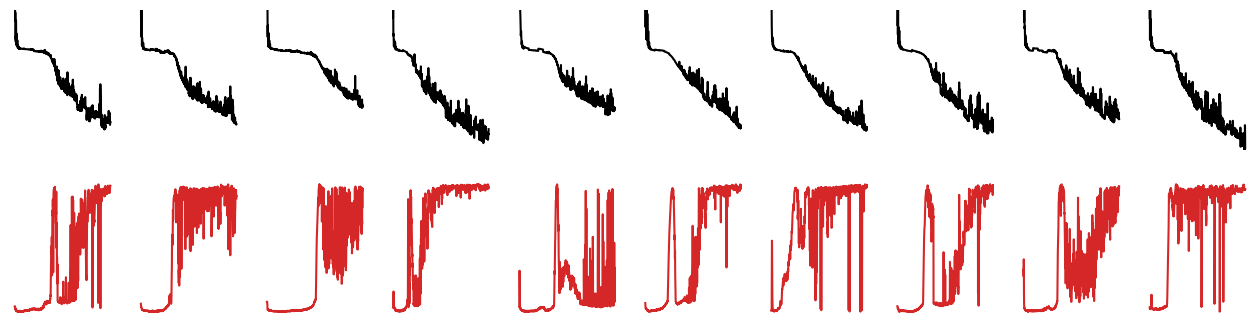

In [13]:
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i_key, key in enumerate(signal_dicts):
    ax[0, i_key].plot(np.log10(signal_dicts[key]['test_loss']), color='k')
    ax[0, i_key].axis('off')
    ax[1, i_key].plot(signal_dicts[key]['lengths'], color='C3')
    ax[1, i_key].axis('off')
    ax[0, i_key].set_ylim([-3, -2])

In [ ]:
fig, ax = plt.subplots(4, 10, figsize=(16, 8))
for i_key, key in enumerate(signal_dicts):
    ax[0, i_key].plot(np.log10(signal_dicts[key]['test_loss']), color='k')
    ax[0, i_key].axis('off')
    ax[1, i_key].plot(signal_dicts[key]['lengths'], color='C3')
    ax[1, i_key].axis('off')
for i_key, key in enumerate(signal_dicts_0):
    ax[2, i_key].plot(np.log10(signal_dicts_0[key]['test_loss']), color='k')
    ax[2, i_key].axis('off')
    ax[3, i_key].plot(signal_dicts_0[key]['lengths'], color='C3')
    ax[3, i_key].axis('off')

In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(8, 20))
for i_seed in range(10):
    for i_lr, lr in enumerate(['0,003', '0,01']):
        key = 'analyze_length_testloss_lr_seed={}_lr={}'.format(i_seed, lr)
        ax[i_seed, i_lr].plot(10 *(np.log10(signal_dicts[key]['test_loss']) + 2))
        ax[i_seed, i_lr].plot(signal_dicts[key]['lengths'])

In [ ]:
i_cp = 900
cp_0 = checkpoints_dicts_0['analyze_length_test_loss_seed=0']['checkpoints']['checkpoint_{}'.format(i_cp)]
cp_1 = checkpoints_dicts_1['analyze_length_testloss_ctx1_seed=0']['checkpoints']['checkpoint_{}'.format(i_cp)]

In [ ]:
task = Context_Dependent_Decision_Task(T_trial=100, input_var=0.1, report_cue=True)
data = task.gen_data(0, 1000)
colors = ['#0000FF', '#D62728']
col1 = '#FF0000'
col2 = '#0000FF'
col3 = '#00FF00'
col4 = '#FFFF00'
probe_colors = linearly_interpolate_colors(col1, col2, 10) + linearly_interpolate_colors(col3, col4, 10)
ssa = State_Space_Analysis(cp_0, data, n_PCs=2)
ssa = plot_checkpoint_results(cp_0, data, ssa,
                              plot_fixed_points=True,
                              plot_cluster_means=True,
                              plot_graph_structure=False,
                              plot_test_points=False,
                              n_test_samples=None,
                              T_per_sample=100,
                              test_alpha=1,
                              plot_probe=True,
                              n_probes=20,
                              probe_colors=probe_colors,
                              eig_norm_color=True,
                              graph_key='adjmat_input_1')
W_in_ = cp_0['rnn'].W_in[:,0]
W_out_ = cp_0['rnn'].W_out[0]
w_in = ssa.transform(W_in_)
w_in = w_in / norm(w_in)
w_out = ssa.transform(W_out_)
w_out = w_out / norm(w_out)
#plt.title(key + ', in-out-alignment = {}'.format(normalized_dot_product(W_in_, W_out_)))
#plt.title(key)
if True:
    #ssa.ax.plot([-w_in[0], w_in[0]],
    #            [-w_in[1], w_in[1]], color='k', linewidth=2)
    ssa.ax.plot([-w_out[0], w_out[0]],
                [-w_out[1], w_out[1]], color='g', linewidth=2)
    window_size = 1.2

In [ ]:
task = Context_Dependent_Decision_Task(T_trial=100, input_var=0.1, report_cue=True)
data = task.gen_data(0, 1000)
colors = ['#0000FF', '#D62728']
col1 = '#FF0000'
col2 = '#0000FF'
col3 = '#00FF00'
col4 = '#FFFF00'
probe_colors = linearly_interpolate_colors(col1, col2, 10) + linearly_interpolate_colors(col3, col4, 10)
ssa = State_Space_Analysis(cp_1, data, n_PCs=2)
ssa = plot_checkpoint_results(cp_1, data, ssa,
                              plot_fixed_points=True,
                              plot_cluster_means=True,
                              plot_graph_structure=False,
                              plot_test_points=False,
                              n_test_samples=None,
                              T_per_sample=100,
                              test_alpha=1,
                              plot_probe=True,
                              n_probes=20,
                              probe_colors=probe_colors,
                              eig_norm_color=True,
                              graph_key='adjmat_input_1')
W_in_ = cp_1['rnn'].W_in[:,0]
W_out_ = cp_1['rnn'].W_out[0]
w_in = ssa.transform(W_in_)
w_in = w_in / norm(w_in)
w_out = ssa.transform(W_out_)
w_out = w_out / norm(w_out)
#plt.title(key + ', in-out-alignment = {}'.format(normalized_dot_product(W_in_, W_out_)))
#plt.title(key)
if True:
    #ssa.ax.plot([-w_in[0], w_in[0]],
    #            [-w_in[1], w_in[1]], color='k', linewidth=2)
    ssa.ax.plot([-w_out[0], w_out[0]],
                [-w_out[1], w_out[1]], color='g', linewidth=2)
    window_size = 1.2

In [ ]:
np.std(cp_1['fixed_points'][np.where(cp_1['cluster_labels'] == 0)], axis=0).mean()

In [ ]:
np.std(cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)], axis=0).mean()

In [ ]:
M = distance.pdist(cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)], 'euclidean')

In [ ]:
M = distance.squareform(M)

In [ ]:
np.where(M == np.max(M))

In [ ]:
r_2 = cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)][57]
W_rec = cp_0['rnn'].W_rec.copy()
W_in = cp_0['rnn'].W_in.copy()
b_rec = cp_0['rnn'].b_rec.copy()
c_2 = np.eye(5)[2]
c_1 = np.eye(5)[3]
Delta_c = c_2 - c_1
h_2 = W_rec.dot(r_2) + W_in.dot(c_2) + b_rec
Delta_r = np.linalg.inv(np.eye(32) - np.diag((1 - np.tanh(h_2))**2).dot(W_rec)).dot(np.diag((1 - np.tanh(h_2))**2)).dot(W_in.dot(Delta_c))
r_1 = r_2 - Delta_r

In [ ]:
r_2_ = cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)][200]
W_rec = cp_0['rnn'].W_rec.copy()
W_in = cp_0['rnn'].W_in.copy()
b_rec = cp_0['rnn'].b_rec.copy()
c_2 = np.eye(5)[2]
c_1 = np.eye(5)[3]
Delta_c = c_2 - c_1
h_2 = W_rec.dot(r_2_) + W_in.dot(c_2) + b_rec
Delta_r = np.linalg.inv(np.eye(32) - np.diag((1 - np.tanh(h_2))**2).dot(W_rec)).dot(np.diag((1 - np.tanh(h_2))**2)).dot(W_in.dot(Delta_c))
r_1_ = r_2 - Delta_r

In [ ]:
M1 = distance.pdist(cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 0)], 'euclidean')
M1 = distance.squareform(M1)
np.where(M1 == np.max(M1))

In [ ]:
r_1_real = cp_1['fixed_points'][np.where(cp_1['cluster_labels'] == 0)][82]

In [ ]:
r_1_real_ = cp_1['fixed_points'][np.where(cp_1['cluster_labels'] == 0)][13]

In [ ]:
plt.plot(r_1)
plt.plot(r_1_)
plt.plot(r_1_real)
plt.plot(r_1_real_)


In [ ]:
plt.plot(signal_dicts_0['analyze_length_test_loss_seed=0']['lengths'])

In [ ]:
root_name = 'length_testloss_lr'
results_dir = '/home/om2382/learning-dynamics/results/misc'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                     'checkpoints': checkpoints}

In [ ]:
fig, ax = plt.subplots(4, 10, figsize=(24, 6))
for i_seed in range(10):
    for i_lr, lr in enumerate(['01', '003']):
        test_loss = []
        lengths = []
        key = 'analyze_length_testloss_lr_seed={}_lr=0,{}'.format(i_seed, lr)
        CPs = checkpoints_dicts[key]['checkpoints']
        for i_cp in range(0, 1000, 100):
            test_loss.append(np.log10(get_checkpoint_loss))
            lengths.append(get_checkpoint_maximum_cluster_distances)
        ax[2*i_lr, i_seed].plot(test_loss, 'k')
        ax[2*i_lr + 1, i_seed].plot(lengths, 'C3')